In [1]:
# Load all packages
from os.path import join
import mat73
import matplotlib.pyplot as plt
import numpy as np
import mne
from tqdm import tqdm # For progress bar

# Functions for loading and formatting data

In [2]:
# Load data into dictionary
def LoadData(subjectpath,rootdir="neuro_data"):
    """Loads .mat data into dictionary

    Args:
        subjectfile (str): filename of subject .mat file
        rootdir (str, optional): path to directory holding subject data. Defaults to "neuro_data".

    Returns:
        dict: dictionary with subject data
    """
    DataPath = join(rootdir,subjectpath)
    data_dict = mat73.loadmat(DataPath, use_attrdict=True)
    return data_dict["data"]

In [3]:
# Function to transform data to appropriate shape

def DimConvertFunc(trial, all_channels, bad_channels, n_samples):
    """Converts 60 channel data to 74 channel data with dummy info, in order to fit EasyCap format.

    Args:
        trial (array of floats): data from channel
        moving_window (int, optional): moving average window to smoothen data for visualization. Defaults to 0.

    Returns:
        _type_: (n_trials, n_samples)
    """
    newTrial = np.zeros((len(all_channels),n_samples))
    j = 0
    filler = [0]*n_samples
    for i, ch in enumerate(all_channels):
        if ch in bad_channels:
            newTrial[i]=filler
        else:
            newTrial[i]=trial[j]/(10**6) # Divide with ~10**6 to convert muV to V
            j += 1
    return newTrial

In [4]:
def create_MNE_events(trialinfo):
    """Create event data structure with MNE compatible format from data["trialinfo"]

    Args:
        trialinfo (_type_): data["trialinfo"] as provided in the MatLab data from M. Sandsten.

    Returns:
        _type_: MNE compatible event data structure
    """

    n = len(trialinfo)
    metadata = [0]*n
    for i, trialinfo in enumerate(trialinfo):
        # side : left = 1, right = 2
        # side_accuracy : Correct (1) Incorrect (2) No response (3) Almost correct (4)
        metadata[i] = {"side":int(trialinfo[0]["side"]),"accurate":int(trialinfo[0]["side_accuracy"])}

    event_label = [event["side"] for event in metadata] # actual info, must be converted to shape (N,3)
    events = np.zeros((n,3))
    events[:,2] = np.array(event_label)  #Add labels to 3rd column, 2nd column irrelevant, but shape needed
    events[:,0] = np.array(range(n))     #Add dummy IDs to first column
    events = events.astype(int)
    return events

In [5]:
def create_MNE_EpochsArray(data):
    # Constants
    sfreq = data["fsample"] # Sampling frequency
    used_channels = [ch[0].upper() for ch in data["label"]]
    all_channels = [ch[0] for ch in data["elec"]["label"]] # Not all upper case
    used_channel_case = [ch for ch in all_channels if ch.upper() in used_channels] # match cases
    bad_channels = list(set(all_channels).difference(set(used_channel_case))) # Channels not used
    n_samples = len(data["trial"][0][0]) # Amount of measurements for each channel in a trial

    # MNE data structures

    info = mne.create_info(all_channels, sfreq, "eeg")
    info.set_montage('easycap-M1')
    info["bads"] = bad_channels

    events = create_MNE_events(data["trialinfo"])
    event_dict = {"auditory/left":1, "auditory/right":2}

    # Create array with 74 instead of 60 channel data to fit Easycap Scheme
    rawdata_UpScaledDim = np.array([DimConvertFunc(epoch, all_channels, bad_channels, n_samples) for epoch in data["trial"]])
    epochs = mne.EpochsArray(rawdata_UpScaledDim, info, tmin=-2, events=events, event_id=event_dict, baseline=(-2,0))
    infodict = {"epochs":epochs, 
                "used_channels":used_channel_case, 
                "bad_channels":bad_channels, 
                "events":events, 
                "event_dict":event_dict}
    return infodict

## For saving epoched data

In [6]:
def saveEpoFIF(subject, destination):
    """Takes .mat eeg file provided by M. Sandsten and converts to MNE epoch .fif file

    Args:
        subject (string): name of subject .mat file
        destination (string): location to save -epo.fif file
    """
    data = LoadData(subject)
    epodict = create_MNE_EpochsArray(data)
    filename = subject.split(".")[0]+"-epo.fif"
    DataPath = join(destination,filename)
    epodict["epochs"].save(DataPath)

In [8]:
#destination = join("neuro_data","raw_epofif")
#saveEpoFIF("dataSubj15.mat",destination)

# TFR visualization

In [7]:
data = LoadData("dataSubj10.mat")
epodict = create_MNE_EpochsArray(data)
epochs = epodict["epochs"]

Not setting metadata
352 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [15]:
def GenerateTFRHelper(epoch, channel, freqs, n_cycles, decim=3):
    """ Generates Time-Frequency representation for given channels of EEG data.clear.
        Images are generated without axes or anything obsolete, only the TFR is saved.

    Args:
        epoch (_type_): The sample for which to create spectrograms
        channels (_type_): Channel for spectrogram
        freqs (_type_): Array of desired frequencies
        n_cycles (_type_): ???
        savepath (_type_): Path to folder where images will be saved
        decim (int, optional): Down-sampling factor to speed up calculation. Defaults to 3.
    """
    power = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=decim)
    power.plot([channel], baseline=(-2,0), mode="logratio", tmin=0, tmax=4, cmap="binary_r", colorbar=False, show=False, verbose=False)

In [8]:
SFREQ = 500
TIME = [-2,7]

# Resample data, high frequencies irrelevant
newfreq = 128
epochs_resampled = epochs.resample(newfreq)

logarithmic

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.2s finished


[<Figure size 640x480 with 1 Axes>]

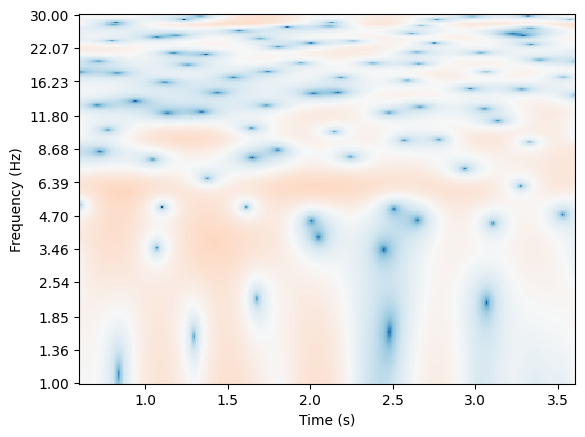

In [30]:
#GenerateTFRHelper(epochs[0],"T8",[1,30],SFREQ/1.,decim=1)
freqs = np.logspace(*np.log10([1,30]), num=300) # Frequencies of interest for spectrogram
power = mne.time_frequency.tfr_morlet(epochs[0], freqs=freqs, n_cycles=freqs/1., use_fft=True, return_itc=False, decim=1)
power.plot(["T8"], baseline=(-2,0), mode="logratio", tmin=0.6, tmax=3.6, colorbar=False, show=False, verbose=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.0s finished


[<Figure size 640x480 with 1 Axes>]

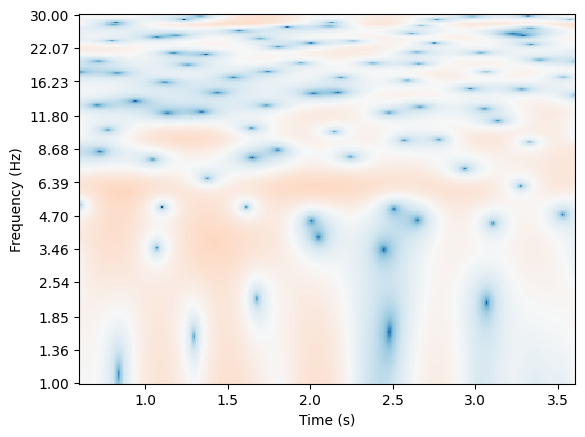

In [29]:
freqs = np.logspace(*np.log10([1,30]), num=300) # Frequencies of interest for spectrogram
power = mne.time_frequency.tfr_morlet(epochs_resampled[0], freqs=freqs, n_cycles=freqs/1., use_fft=True, return_itc=False, decim=1)
power.plot(["T8"], baseline=(-2,0), mode="logratio", tmin=0.6, tmax=3.6, colorbar=False, show=False, verbose=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.1s finished


[<Figure size 640x480 with 2 Axes>]

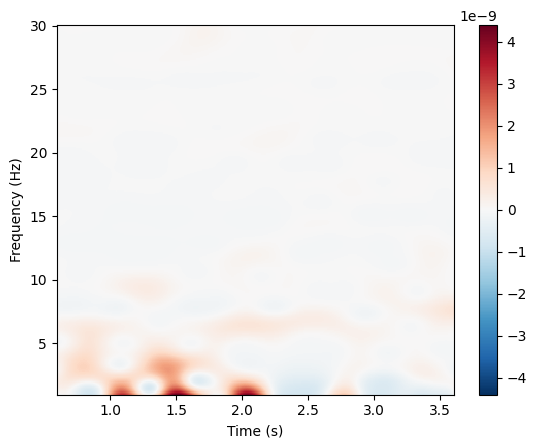

In [9]:
freqs = np.linspace(1,30,300) # Frequencies of interest for spectrogram
power = mne.time_frequency.tfr_morlet(epochs_resampled[0], freqs=freqs, n_cycles=freqs/1., use_fft=True, return_itc=False, decim=1)
power.plot(["T8"], baseline=(-2,0), tmin=0.6, tmax=3.6, colorbar=True, show=False, verbose=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.3s finished


[<Figure size 640x480 with 2 Axes>]

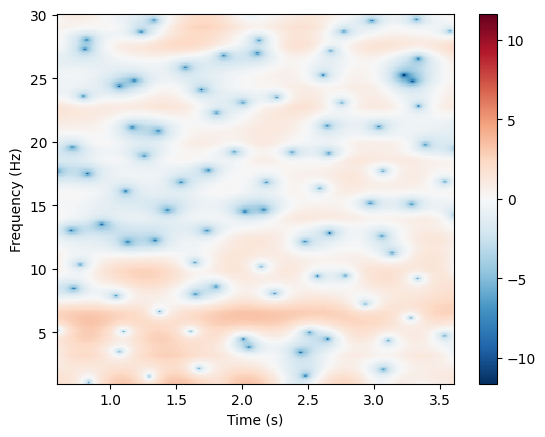

In [27]:
freqs = np.linspace(1,30,300) # Frequencies of interest for spectrogram
power = mne.time_frequency.tfr_morlet(epochs_resampled[0], freqs=freqs, n_cycles=freqs/1., use_fft=True, return_itc=False, decim=1)
power.data = np.log(power.data)
power.plot(["T8"], baseline=(-2,0), tmin=0.6, tmax=3.6, colorbar=True, show=False, verbose=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.1s finished


[<Figure size 640x480 with 2 Axes>]

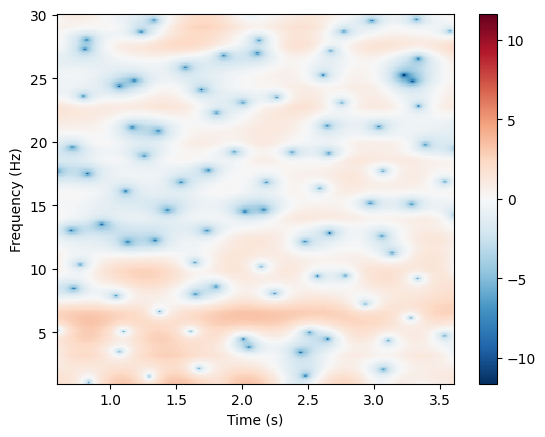

In [45]:
freqs = np.linspace(1,30,300) # Frequencies of interest for spectrogram
power = mne.time_frequency.tfr_morlet(epochs[0], freqs=freqs, n_cycles=freqs/1., use_fft=True, return_itc=False, decim=1)
power.data = np.log(power.data)
power.plot(["T8"], baseline=(-2,0), tmin=0.6, tmax=3.6, colorbar=True, show=False, verbose=False)

In [47]:
# Resample data, high frequencies irrelevant
newfreq = 64
epochs_resampled = epochs.resample(newfreq)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.3s finished


<Figure size 224x224 with 0 Axes>

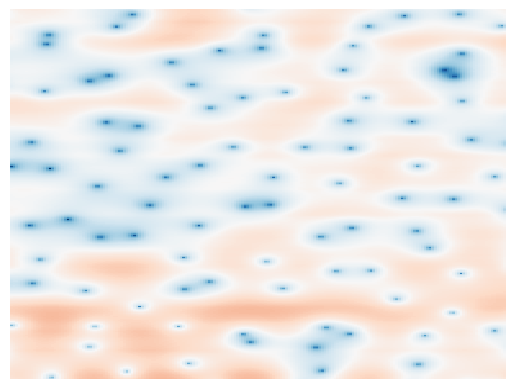

In [60]:
# Do this outside Jupyter...
freqs = np.linspace(1,30,300) # Frequencies of interest for spectrogram
power = mne.time_frequency.tfr_morlet(epochs_resampled[0], freqs=freqs, n_cycles=freqs/1., use_fft=True, return_itc=False, decim=1)
power.data = np.log(power.data)
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.figure(figsize=(224*px,224*px))
fig = power.plot(["T8"], baseline=(-2,0), tmin=0.6, tmax=3.6, colorbar=False, show=False, verbose=False)
plt.axis('off')

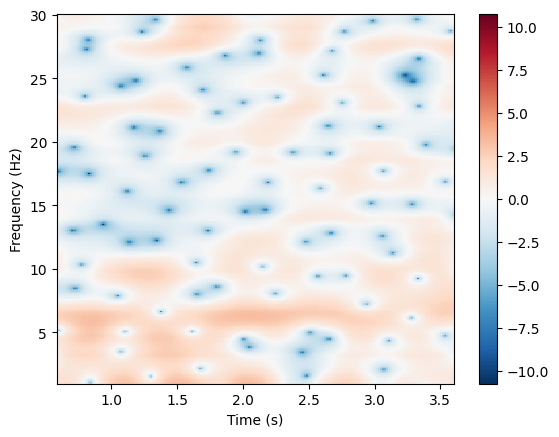

In [52]:
mydpi=120

plt[1]

# triple mono channel stacking

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


(300, 1152, 3)
333 717


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


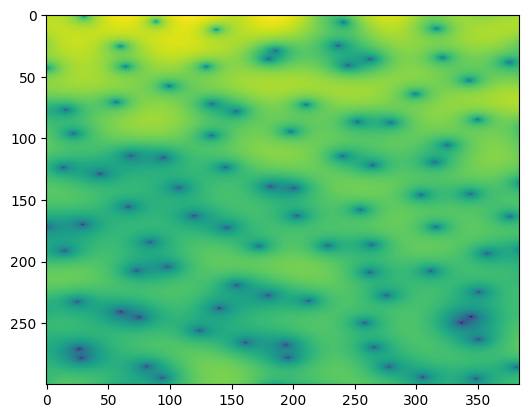

In [52]:
# We attempt to generate grayscale images for 3 channels and stack into a single rgb image
# In order to pack more information into one image.

freqs = np.linspace(1,30,300) # Frequencies of interest for spectrogram
power = mne.time_frequency.tfr_morlet(epochs_resampled[0],picks=["T8","Cz","T7"], freqs=freqs, n_cycles=freqs/1., use_fft=True, return_itc=False, decim=1)
power.data = np.log(power.data)
rgb = np.transpose(power.data,(1,2,0))
print(rgb.shape)
startindex = int(np.ceil(newfreq*2.6))
endindex = int(np.ceil(newfreq*5.6))
print(startindex, endindex)
plt.imshow(rgb[:,startindex:endindex,0])

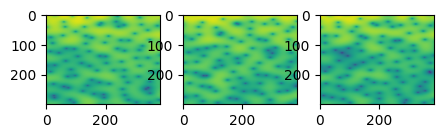

In [56]:
fig, axarr = plt.subplots(1,3, figsize=(5,15))
axarr[0].imshow(rgb[:,startindex:endindex,0])
axarr[1].imshow(rgb[:,startindex:endindex,1])
axarr[2].imshow(rgb[:,startindex:endindex,2])

In [78]:
from PIL import Image

img = Image.fromarray(rgb[:,startindex:endindex,:],"RGB")
img.show()
#plt.imshow(np.array(img)[:,:,2])